# アンサンブル学習　ー異なるモデルの組み合わせ
- 多くの場合、分類器を個別に使用するよりも高い予測性能が実現される。
- 多数決に基づく予測
- トレーニングデータセットのランダムな組み合わせを繰り返し抽出することによる過学習の抑制
- 誤答から学習する「弱学習器」による強力なモデルの構築

# 7.1 アンサンブルによる学習
- アンサンブル法の目的は、様々な分類器を１つのメタ分類器として組み合わせることにある。この方法であれば、分類器を個別に使用するするよりも高い汎化性能を得られる。
- 最もよく知られるアンサンブル法は多数決の原理を用いるものである。
- 分類器の大多数、つまり過半数によって予測されているクラスが選択されることを意味する。
- 多数決の原理を多クラスの分類問題に一般化するのは簡単で、相対多数決と呼ばれる。この場合、最も得票数の多いクラスラベルが選択される。
- 手法としては、サポートベクトルマシン、ロジスティック回帰分類器など、さまざまな分類アルゴリズムを使ってアンサンブルを構築する方法
- 同じ分類アルゴリズムでトレーニングデータセットの異なる部分を学習させることもできる。
- 個々の分類器$C_{j}$で予測されたクラスラベルをまとめ、最も得票数の多いクラスラベル$\hat{y}$を選択する。（以下の式のmodeは最頻値を意味する。）
$$\hat{y} = mode\{ C_{1}(x),C_{2}(x), \ldots ,C_{m}(x) \}$$
- 例えばクラス1=-1、クラス2=+1の二値分類タスクでは、多数決予測を以下の様に記述できる。
$$C(x) = sign \left[ \sum^{m}_{j} C_{j}(x) \right] = \begin{cases} 1 & (\Sigma_{j}C_{j}(x) \geq 0) \\ -1 & (\Sigma_{j}C_{j}(x) < 0)\end{cases}$$

- アンサンブルのほうが分類器を単体で使用した場合よりも効果が期待できる。
- 二値分類タスクのn個のベース分類器の誤分類率がすべて等しく$\varepsilon$であるとするする。さらに、それぞれの分類器が独立していて、誤分類率に相関が無いものとする。この前提では、ベース分類器のアンサンブルの誤分類率を二項分布の確率質量関数として表すことができる。
$$P(y \geq k) = \sum^{n}_{k} \binom{n}{k} \varepsilon^{k}(1-\varepsilon)^{n-k} ~ \varepsilon_{ensemble}$$
- 誤分類率0.25の11個のベース分類器で計算すると
$$P(y\geq6) = \sum^{11}_{k=6}\binom{11}{k}\varepsilon^{k}(1-\varepsilon)^{11-k} = 0.034$$
- すべての条件が満たされているとすれば、アンサンブルの誤分類率（0.034）は個々の分類器の誤分類率よりはるかに低いことがわかる。

In [1]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier,error):
    k_start = int(math.ceil(n_classifier/2.0))
    probs = [comb(n_classifier,k) * error**k * (1-error)**(n_classifier-k) for k in range(k_start,n_classifier+1)]
    return sum(probs)

print ensemble_error(n_classifier=11,error=0.25)

0.034327507019


/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


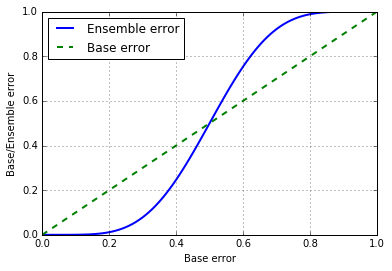

In [2]:
import numpy as np
error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error) for error in error_range]

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(error_range,ens_errors,label='Ensemble error',linewidth=2)
plt.plot(error_range,error_range,linestyle='--',label='Base error',linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

- ベース分類器の性能が当て推量よりも高い限り（$\varepsilon < 0.5$）、アンサンブルの誤分類率は個々のベース分類器の誤分類率に常に勝っている。

# 7.2 単純な多数決分類器の実装
- データセットに対する個々の分類器の弱点を補完しあうような、より強力なメタ分類器を構築する。
- アルゴリズム毎に信頼度に関する重みが関連付けられている。
- 重み付きの多数決を数学的に表すと
$\newcommand{\argmax}{\mathop{\rm arg~max}\limits}$
$\newcommand{\argmin}{\mathop{\rm arg~min}\limits}$
$$\hat{y} = \argmax_{i}\sum^{m}_{j=1}w_{j}\chi_{A}(C_{j}(\vec{x})=i)$$

- $\chi_{A}$は「$C_{j}(\vec{x})=i \, (i\in A)$」の特性関数を表し,Aはクラスラベルの集合を表す。
- それぞれの分類器の重みが等しい場合は、以下のように簡略化できる。
$$\hat{y} = mode\{ C_{1}(\vec{x}),C_{2}(\vec{x}),\ldots ,C_{m}(\vec{x}) \}$$
- 具体的なもみの値で計算してみると、重みがある場合とない場合$\hat{y}$の値は変わることがある。

In [3]:
np.argmax(np.bincount([0,0,1],weights=[0.2,0.2,0.6]))

1

- アンサンブルの分類器がうまく調整されている場合は、多数決にクラスラベルを使用するのではなく、予測されたクラスの確率を使用するのが良いかもしれない。
- $p_{ij}$はクラスラベル$i$に対して、$j$番目の分類器が予測した確率を表す。
$$\hat{y} = \argmax_{i} \sum^{m}_{j=1}w_{j}p_{ij}$$

In [4]:
#クラスの確率に基づく重み付きの多数決を実行
ex = np.array([[0.9,0.1],
              [0.8,0.2],
              [0.4,0.6]])
p = np.average(ex,axis=0,weights=[0.2,0.2,0.6])
print p,np.argmax(p)

[ 0.58  0.42] 0


In [16]:
#MajorityVoteClassifierクラスを実装
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator
class MajorityVoteClassifier(BaseEstimator,ClassifierMixin):
    '''多数決アンサンブル分類器
    
    パラメータ
    -----------
    classifiers : array-like, shape = [n_classifier]
        アンサンブルの様々な分類器
        
    vote : str {'classlabel','probability'} (defalt : 'classlabel')
        'classlabel'の場合、クラスラベルの予測はクラスラベルのargmaxに基づく
        'probability'の場合、クラスラベルの予測はクラスの所属確率のargmaxに基づく（分類器が調整済みであることが推奨される）
        
    weights : array-like, shape = [n_classifiers] (optional,defalut=None)
        'int'または'float'型のリストが提供された場合分類器は重要度で重み付けされる
        'weights=None'の場合は均一な重みを仕様
    '''
    def __init__(self,classifiers,vote='classlabel',weights=None):
        self.classifiers = classifiers
        self.named_classfiers = {key: value for key,value in _name_estimators(classifiers)}
        
        self.vote = vote
        self.weights = weights
        
    def fit(self,X,y):
        '''分類器を学習させる
        
        パラメータ
        ---------------
        X : {array-like, sparse matrix},shape = [n_samples,n_features]
            トレーニングサンプルからなる行列
        
        y : array-like, shape = [n_samples]
            クラスラベルのベクトル
        
        戻り値
        ---------------
        self : object
        
        '''
        # LabelEncorderを使ってクラスラベルが0から始まる様にエンコードする
        # self.predictのnp.argmax呼び出しで重要となる
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = []
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self,X):
        '''Xのクラスラベルを予測する
        
        パラメータ
        -------------
        maj_vote : array-like, shape = [n_samples]
            予測されたクラスラベル
            
        '''
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),axis=1)
        else: #'classlabel'での多数決
            
            #clf.predict呼び出しの結果を収集
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            # 各サンプルのクラス確率に重みをかけて足し合わせた値が最大となる列番号を配列として返す
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x,weights=self.weights)),axis=1,arr=predictions)
            
        #　各サンプルに確率の最大値を与えるクラスラベルを抽出
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self,X):
        '''Xのクラス確率を予測する
        
        パラメータ
        -----------------
        X : {array-like, sparse matrix},shape = [n_samples,n_features]
            トレーニングベクトル:n_samplesはサンプルの個数,n_featuresは特徴量の個数
        
        戻り値
        -----------------
        avg_proba : array-like ,shape = [n_samples,n_classes]
        
        '''
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self,deep=True):
        '''GridSearchの実行時に分類器のパラメータ名を取得'''
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            #キーを"分類器の名前_パラメータ名"、バリューをパラメータの値とするディクショナリを生成
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(step.get_params(deep=True)):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)] = value
                    return out

# 7.2.1 多数決方式の分類アルゴリズムを組み合わせる。

In [6]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
#Irisデータセットのサンプルを50%のトレーニングデータと50%のテストデータに分割する。
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1)

In [10]:
#3種類の分類器ーロジスティック回帰、決定木分類、k近傍分類器ーを１つのアンサンブル分類器にまとめる前に、
#トレーニングデータセットを使ってそれらをトレーニングし、10分割交差検証を行ってトレーニングデータセット
#での性能を調べる
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',C=0.001,random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')

pipe1 = Pipeline([['sc',StandardScaler()],['clf',clf1]])
pipe3 = Pipeline([['sc',StandardScaler()],['clf3',clf3]])
clf_labels = ['Logistic Regression','Decision Tree','KNN']
print('10-fold cross validation:\n')
for clf,label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC AUC: %0.3f (+/- %0.3f) [%s]') % (scores.mean(),scores.std(),label)

10-fold cross validation:

ROC AUC: 0.917 (+/- 0.201) [Logistic Regression]
ROC AUC: 0.917 (+/- 0.154) [Decision Tree]
ROC AUC: 0.933 (+/- 0.104) [KNN]


In [17]:
#多数決を使ってクラスラベルを予測するために、個々の分類器をMajorityVoteClassifierオブジェクトで組み合わせてみる。
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]') %(scores.mean(),scores.std(),label)

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]
